In [28]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def C_time(t, C0, Cin, V, Q, k):
    """Analytical solution of dC/dt = (Q/V)(Cin - C) - k*C."""
    b = k + Q / V
    C_inf = (Q / V) * Cin / b
    C_t = C_inf + (C0 - C_inf) * np.exp(-b * t)
    return C_t, C_inf

def k_of_T(T, k_ref=0.3, T_ref=20.0, theta=1.07):
    """
    Simple temperature dependence for k:
        k(T) = k_ref * theta^(T - T_ref)
    """
    return k_ref * (theta ** (T - T_ref))

def percent_removal_after_2tau(V, Q, k, Cin, C0):
    """Percent removal after two residence times 2τ."""
    tau = V / Q
    t_eval = 2.0 * tau
    C_t, C_inf = C_time(np.array([t_eval]), C0, Cin, V, Q, k)
    C_end = C_t[0]
    return 100.0 * (1.0 - C_end / Cin)


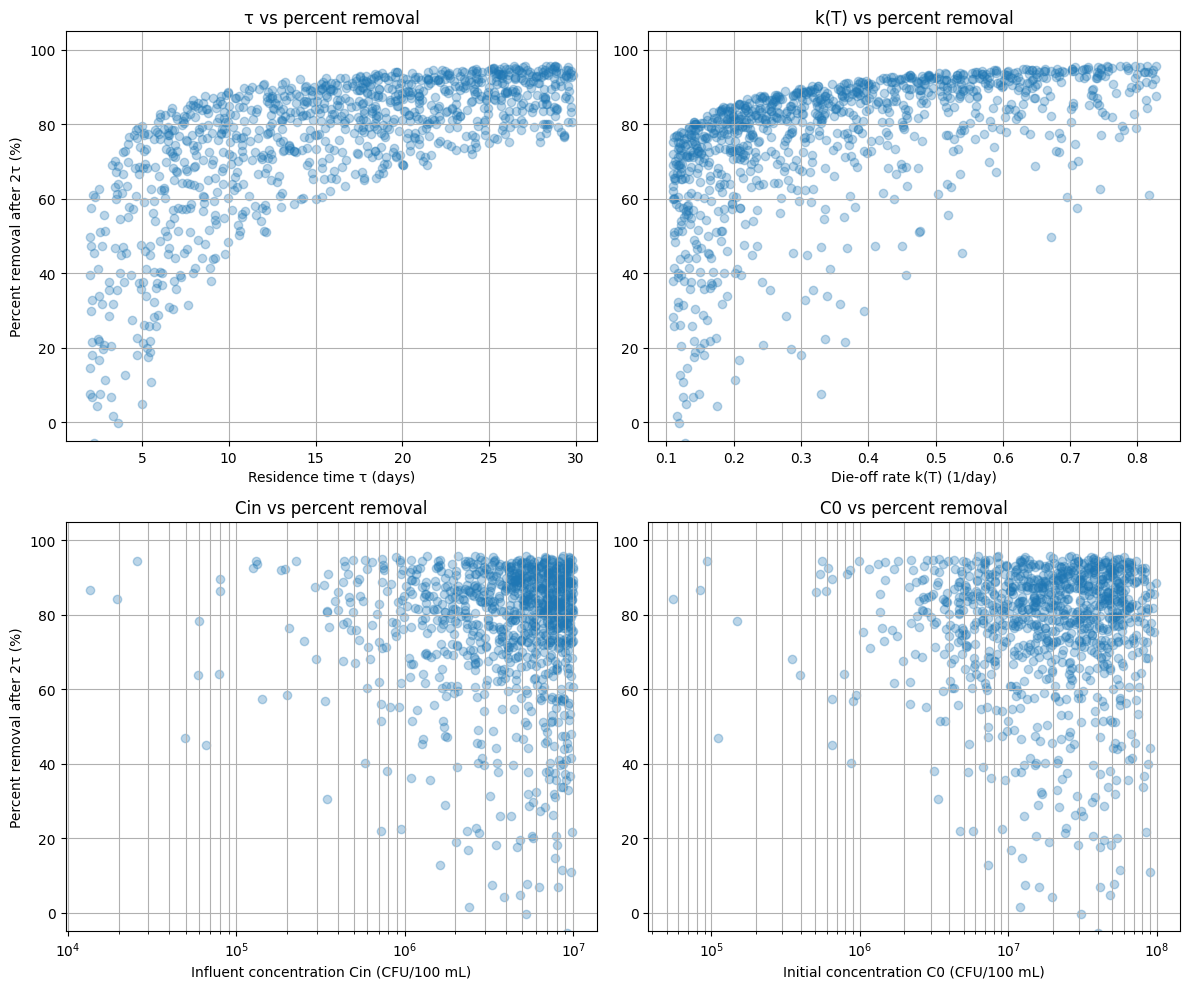

In [29]:
# Monte Carlo sensitivity: scatter plots with clean axes

n_sims   = 1000
Q_design = 200.0              # m^3/day fixed flow

# Sample ranges
tau_samples = np.random.uniform(2.0, 30.0, n_sims)   # residence time τ (days)
T_samples   = np.random.uniform(5.0, 35.0, n_sims)   # temperature (°C)
Cin_samples = np.random.uniform(1e4, 1e7, n_sims)    # influent (CFU/100 mL)
C0_factor   = np.random.uniform(1.0, 10.0, n_sims)   # spike factor
C0_samples  = Cin_samples * C0_factor                # initial pond concentration

# Derived
V_samples = tau_samples * Q_design                   # volume (m^3)
k_samples = k_of_T(T_samples)                        # k(T) (1/day)

# Compute percent removal after 2τ for each sample
removal_list = []
for V, k, Cin, C0 in zip(V_samples, k_samples, Cin_samples, C0_samples):
    rem = percent_removal_after_2tau(V, Q_design, k, Cin, C0)
    removal_list.append(rem)

removal = np.array(removal_list)

# ---- Scatter plots ----
plt.figure(figsize=(12,10))

# 1) τ vs removal
plt.subplot(2,2,1)
plt.scatter(tau_samples, removal, alpha=0.3)
plt.xlabel("Residence time τ (days)")
plt.ylabel("Percent removal after 2τ (%)")
plt.title("τ vs percent removal")
plt.ylim(-5, 105)
plt.grid(True)

# 2) k(T) vs removal
plt.subplot(2,2,2)
plt.scatter(k_samples, removal, alpha=0.3)
plt.xlabel("Die-off rate k(T) (1/day)")
plt.title("k(T) vs percent removal")
plt.ylim(-5, 105)
plt.grid(True)

# 4) Cin vs removal
plt.subplot(2,2,3)
plt.scatter(Cin_samples, removal, alpha=0.3)
plt.xlabel("Influent concentration Cin (CFU/100 mL)")
plt.ylabel("Percent removal after 2τ (%)")
plt.xscale("log")
plt.title("Cin vs percent removal")
plt.ylim(-5, 105)
plt.grid(True, which="both")

# 5) C0 vs removal
plt.subplot(2,2,4)
plt.scatter(C0_samples, removal, alpha=0.3)
plt.xlabel("Initial concentration C0 (CFU/100 mL)")
plt.xscale("log")
plt.title("C0 vs percent removal")
plt.ylim(-5, 105)
plt.grid(True, which="both")


plt.tight_layout()
plt.show()



In [10]:
params = {
    "Residence time τ": tau_samples,
    "Die-off rate k(T)": k_samples,
    "Influent concentration Cin": Cin_samples,
    "Initial concentration C0": C0_samples
}

print("Spearman rank correlations with percent removal:\n")

for name, values in params.items():
    rho, _ = spearmanr(values, removal)
    print(f"{name:30s}  ρ = {rho: .3f}")


Spearman rank correlations with percent removal:

Residence time τ                ρ =  0.681
Die-off rate k(T)               ρ =  0.685
Influent concentration Cin      ρ =  0.040
Initial concentration C0        ρ =  0.003


In [11]:
pip install SALib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 11.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [SALib]32m2/3 [SALib]rocess]
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [16]:
def C_time(t, C0, Cin, V, Q, k):
    """
    Analytical solution of:
    dC/dt = (Q/V)(Cin - C) - k*C
    """
    b = k + Q / V
    C_inf = (Q / V) * Cin / b
    return C_inf + (C0 - C_inf) * np.exp(-b * t)


def k_of_T(T, k_ref=0.3, T_ref=20.0, theta=1.07):
    """
    Temperature-dependent die-off rate
    """
    return k_ref * (theta ** (T - T_ref))


def percent_removal_after_2tau(tau, k, Cin, C0, Q=200.0):
    """
    Percent removal after two residence times (2τ)
    """
    V = tau * Q
    t_eval = 2.0 * tau
    C_t = C_time(np.array([t_eval]), C0, Cin, V, Q, k)
    return 100.0 * (1.0 - C_t[0] / Cin)


In [17]:
np.random.seed(1)
n = 300

tau = np.random.uniform(2.0, 30.0, n)
T   = np.random.uniform(5.0, 35.0, n)
k   = k_of_T(T)
Cin = np.random.uniform(1e4, 1e7, n)
C0  = Cin * np.random.uniform(1.0, 10.0, n)

X = np.vstack([tau, k, Cin, C0]).T
Y = np.array([percent_removal_after_2tau(*row) for row in X])


In [18]:
Xmin, Xmax = X.min(axis=0), X.max(axis=0)
Xn = (X - Xmin) / (Xmax - Xmin)

delta = 0.05
mu_star = []
sigma = []

for i in range(X.shape[1]):
    effects = []
    for j in range(n):
        if Xn[j, i] + delta <= 1.0:
            Xp = Xn[j].copy()
            Xp[i] += delta
            Xp_phys = Xp * (Xmax - Xmin) + Xmin

            y_pert = percent_removal_after_2tau(*Xp_phys)
            effects.append((y_pert - Y[j]) / delta)

    effects = np.array(effects)
    mu_star.append(np.mean(np.abs(effects)))
    sigma.append(np.std(effects))

mu_star = np.array(mu_star)
sigma = np.array(sigma)

labels = ["Residence time τ", "Die-off rate k(T)", "Influent Cin", "Initial C0"]


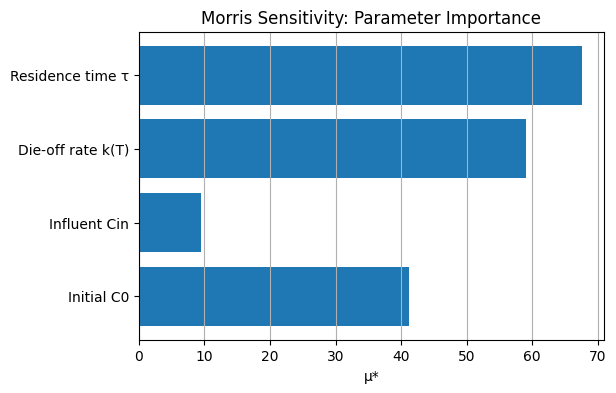

In [30]:
plt.figure(figsize=(6,4))
y_pos = np.arange(len(labels))

plt.barh(y_pos, mu_star)
plt.yticks(y_pos, labels)
plt.xlabel("μ*")
plt.title("Morris Sensitivity: Parameter Importance")
plt.gca().invert_yaxis()
plt.grid(axis="x")

plt.show()


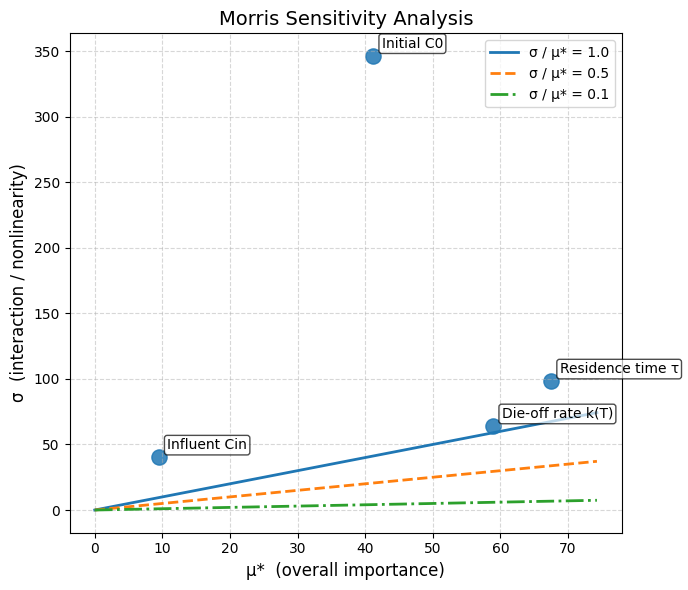

In [31]:
plt.figure(figsize=(7,6))

# Scatter points
plt.scatter(mu_star, sigma, s=120, alpha=0.85)

# Reference lines
mu_line = np.linspace(0, max(mu_star)*1.1, 200)
plt.plot(mu_line, mu_line, linewidth=2, label="σ / μ* = 1.0")
plt.plot(mu_line, 0.5*mu_line, "--", linewidth=2, label="σ / μ* = 0.5")
plt.plot(mu_line, 0.1*mu_line, "-.", linewidth=2, label="σ / μ* = 0.1")

# Annotate points with readable labels
for i, lbl in enumerate(labels):
    plt.annotate(
        lbl,
        (mu_star[i], sigma[i]),
        textcoords="offset points",
        xytext=(6,6),
        ha="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
    )

# Axis labels and title
plt.xlabel("μ*  (overall importance)", fontsize=12)
plt.ylabel("σ  (interaction / nonlinearity)", fontsize=12)
plt.title("Morris Sensitivity Analysis", fontsize=14)

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=True)

plt.tight_layout()
plt.show()
